<a href="https://colab.research.google.com/github/nikita732/GAN/blob/main/Simle_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.08MB/s]


Начало обучения...
Epoch [1/20]  D Loss: 0.7916  G Loss: 2.1895


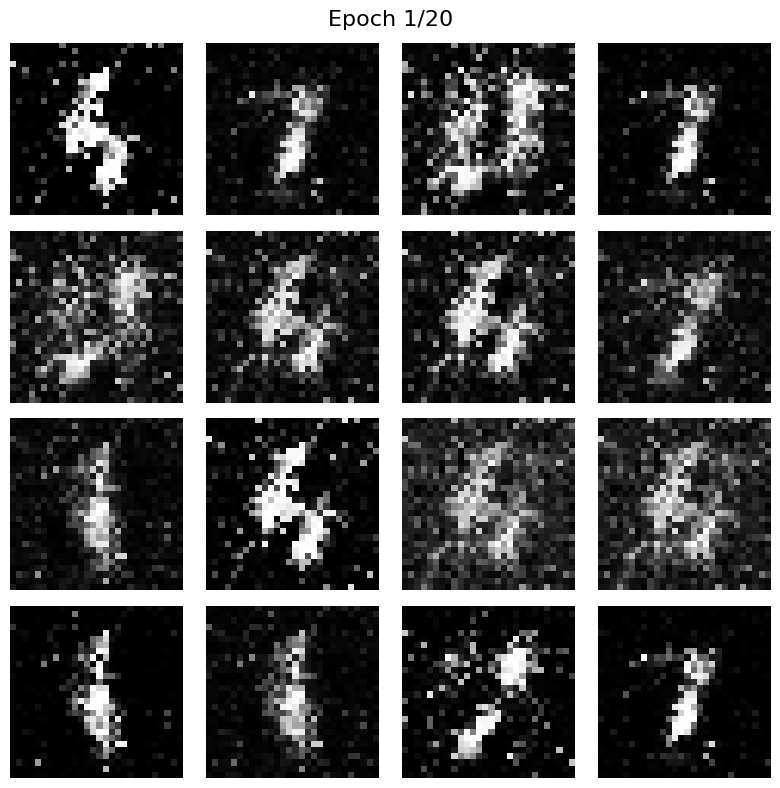

Epoch [2/20]  D Loss: 0.6217  G Loss: 2.7501


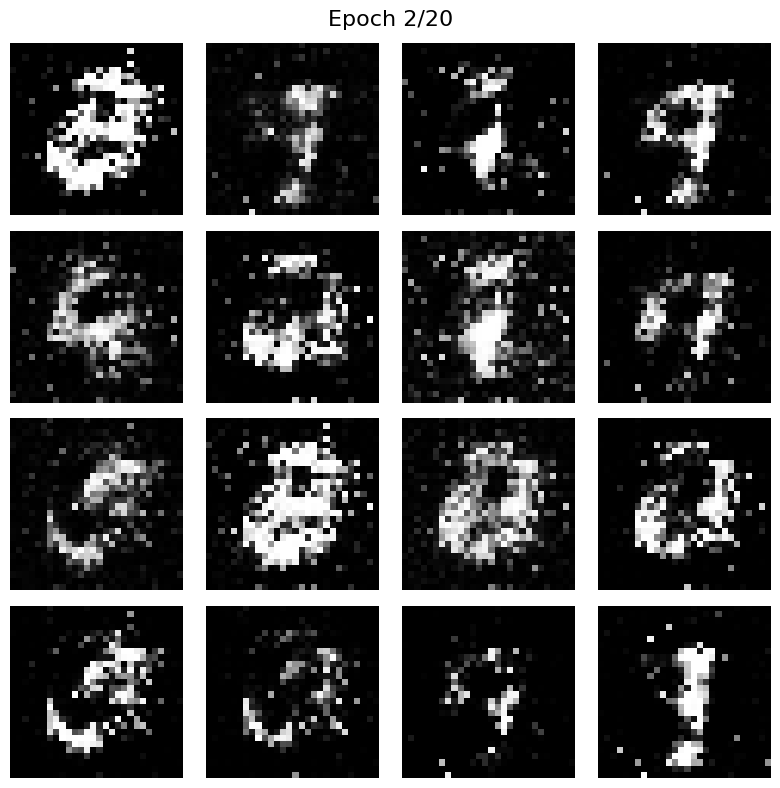

Epoch [3/20]  D Loss: 0.6443  G Loss: 2.3727


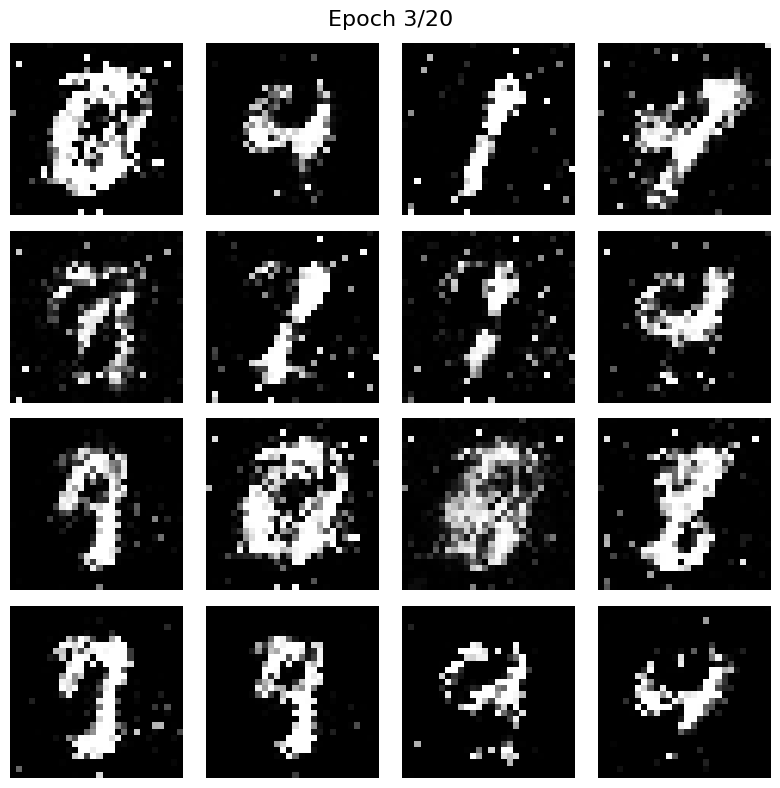

Epoch [4/20]  D Loss: 0.6807  G Loss: 2.1710


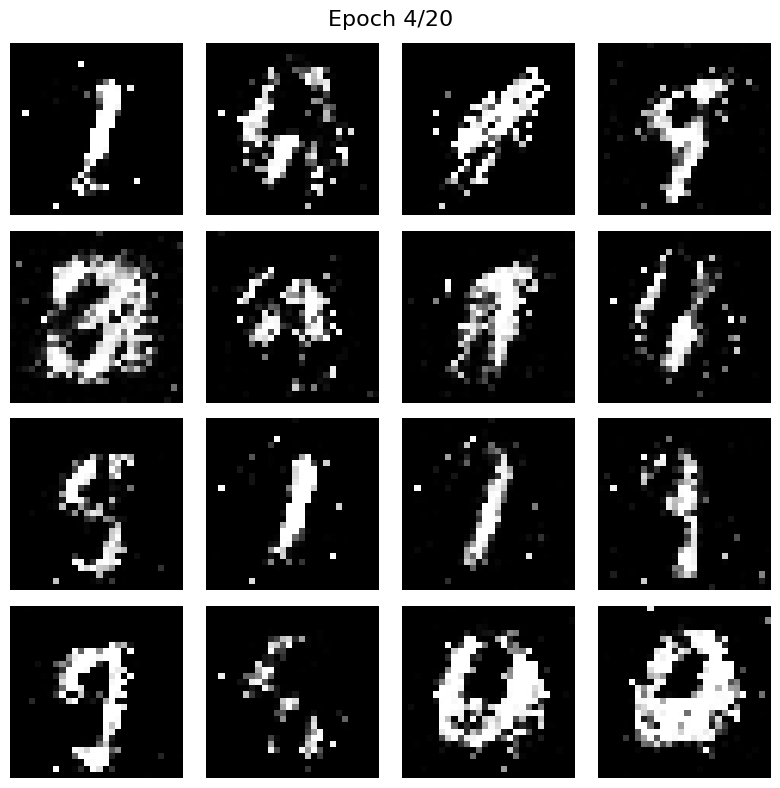

Epoch [5/20]  D Loss: 0.7449  G Loss: 1.9983


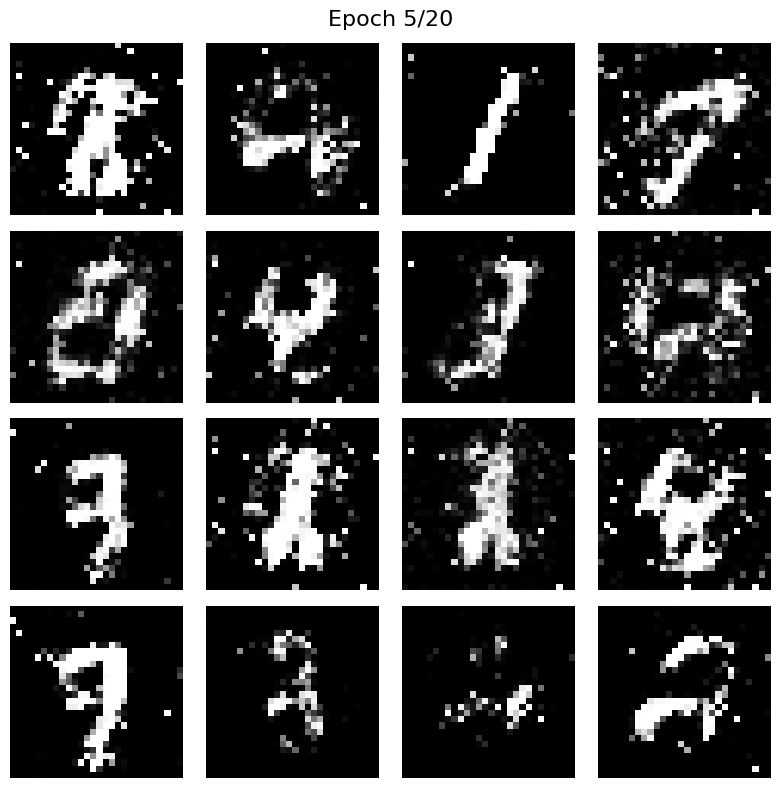

Epoch [6/20]  D Loss: 0.8523  G Loss: 1.7270


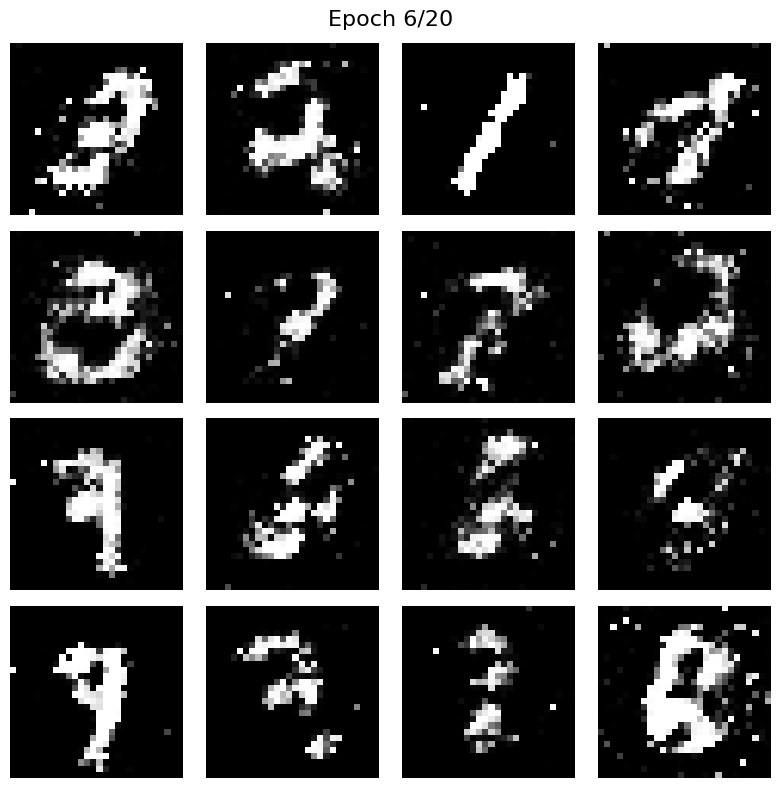

Epoch [7/20]  D Loss: 0.9398  G Loss: 1.5076


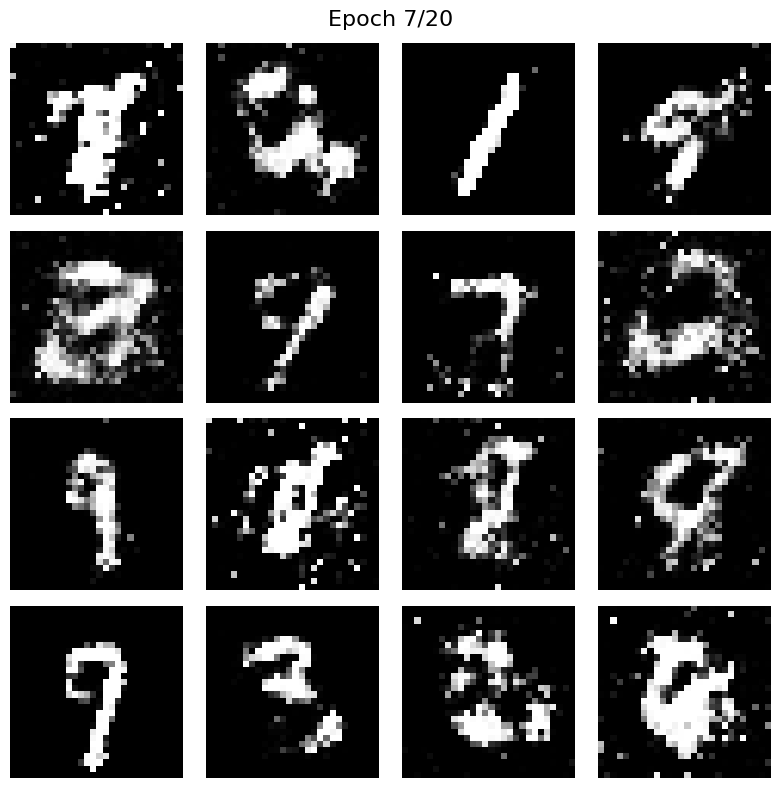

Epoch [8/20]  D Loss: 1.0034  G Loss: 1.3695


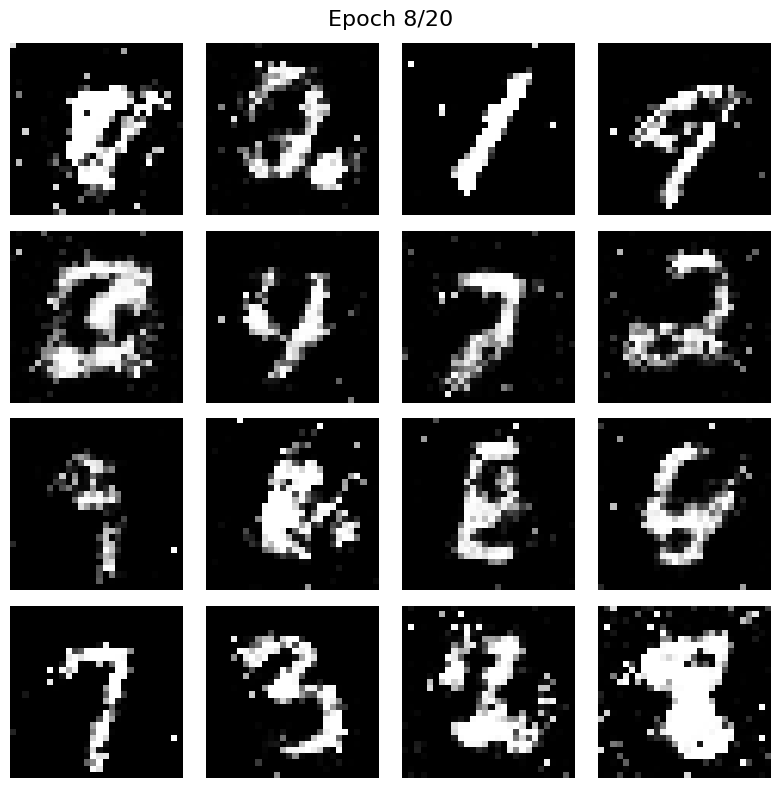

Epoch [9/20]  D Loss: 1.0415  G Loss: 1.3089


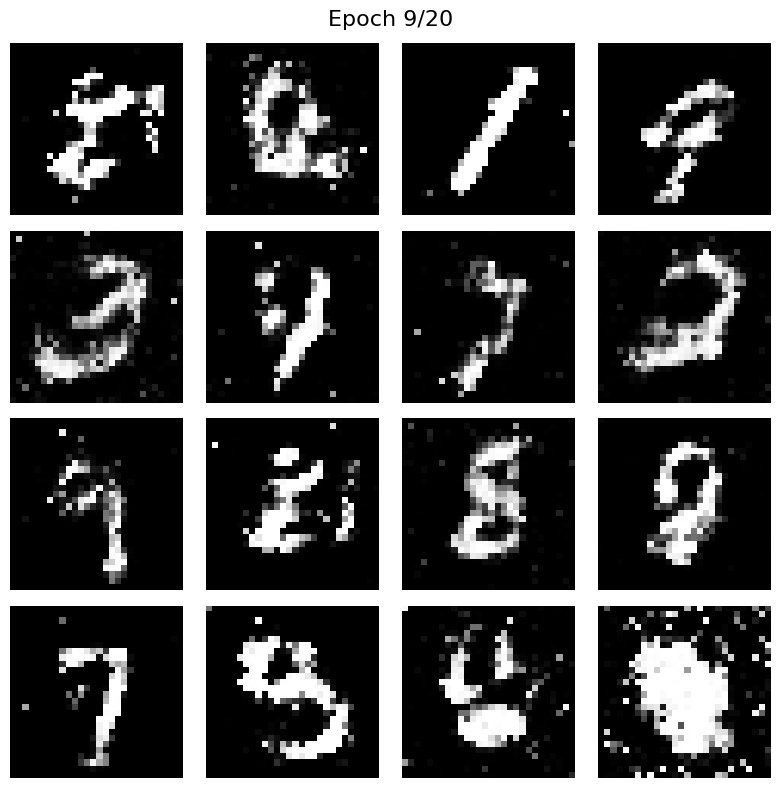

Epoch [10/20]  D Loss: 1.0968  G Loss: 1.2132


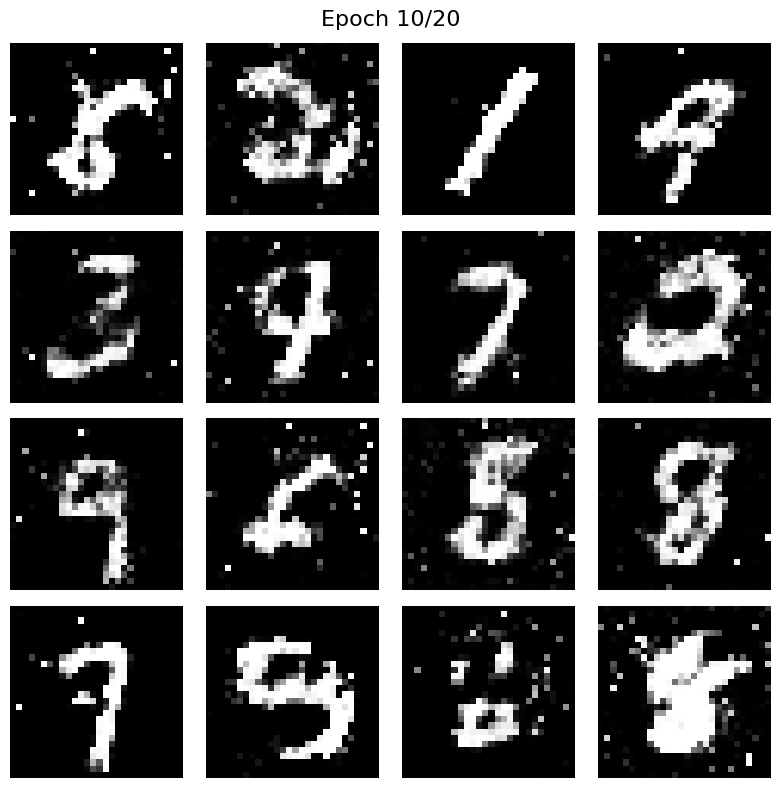

Epoch [11/20]  D Loss: 1.1243  G Loss: 1.1704


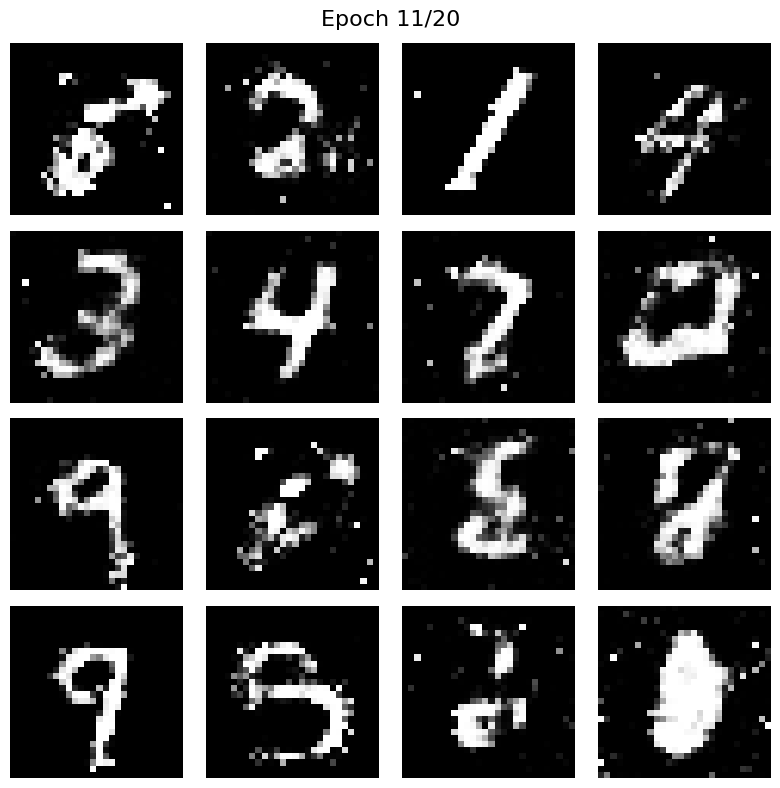

Epoch [12/20]  D Loss: 1.1331  G Loss: 1.1592


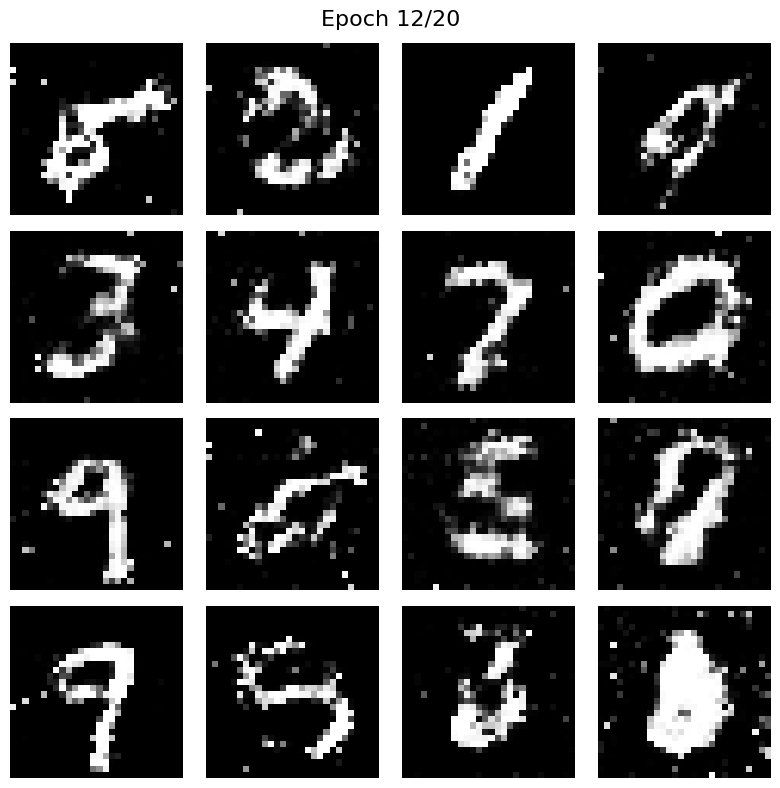

Epoch [13/20]  D Loss: 1.1519  G Loss: 1.1292


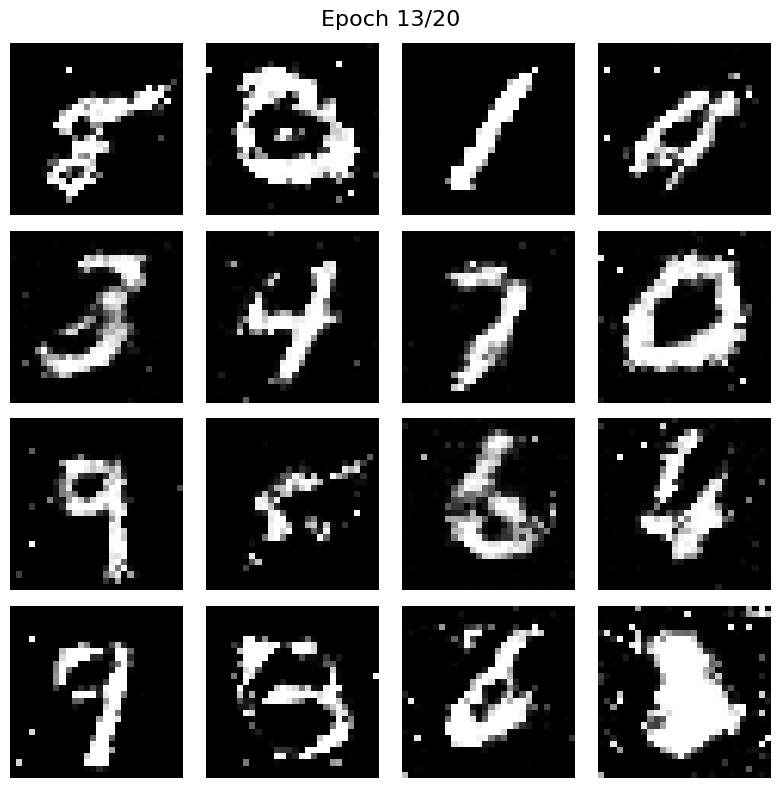

Epoch [14/20]  D Loss: 1.1722  G Loss: 1.0922


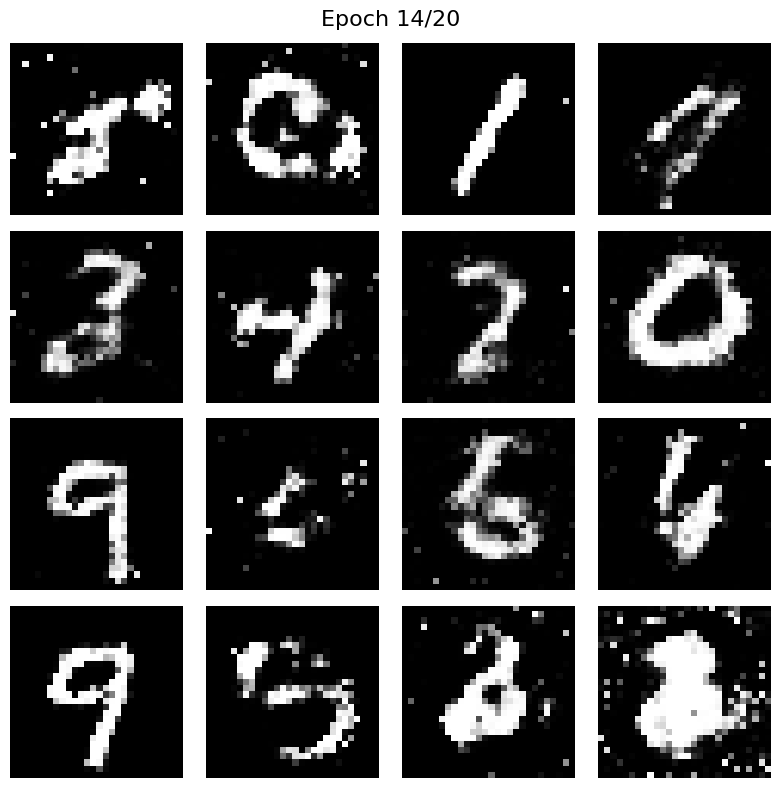

Epoch [15/20]  D Loss: 1.1813  G Loss: 1.0746


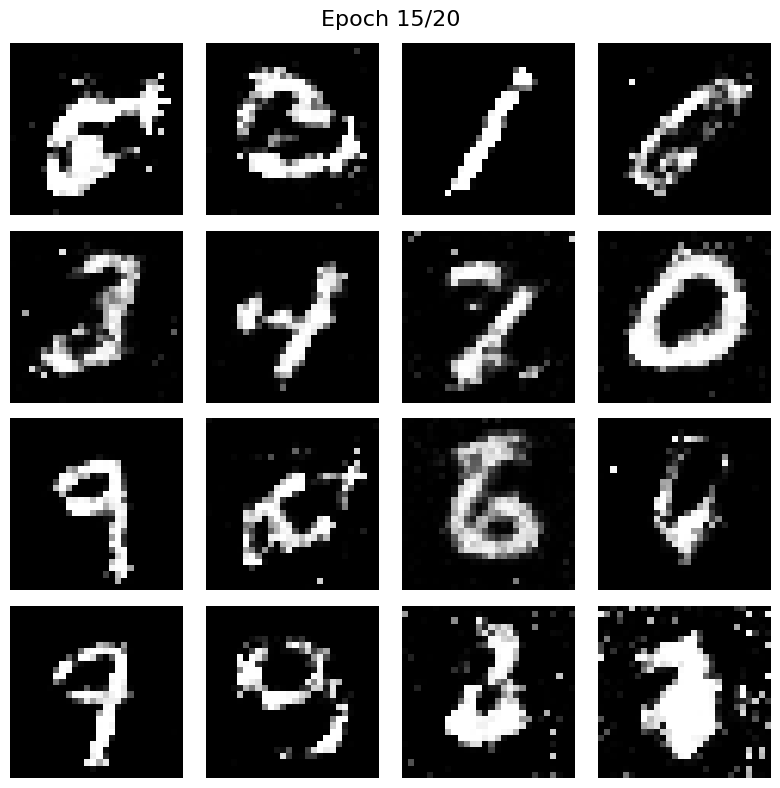

Epoch [16/20]  D Loss: 1.1920  G Loss: 1.0685


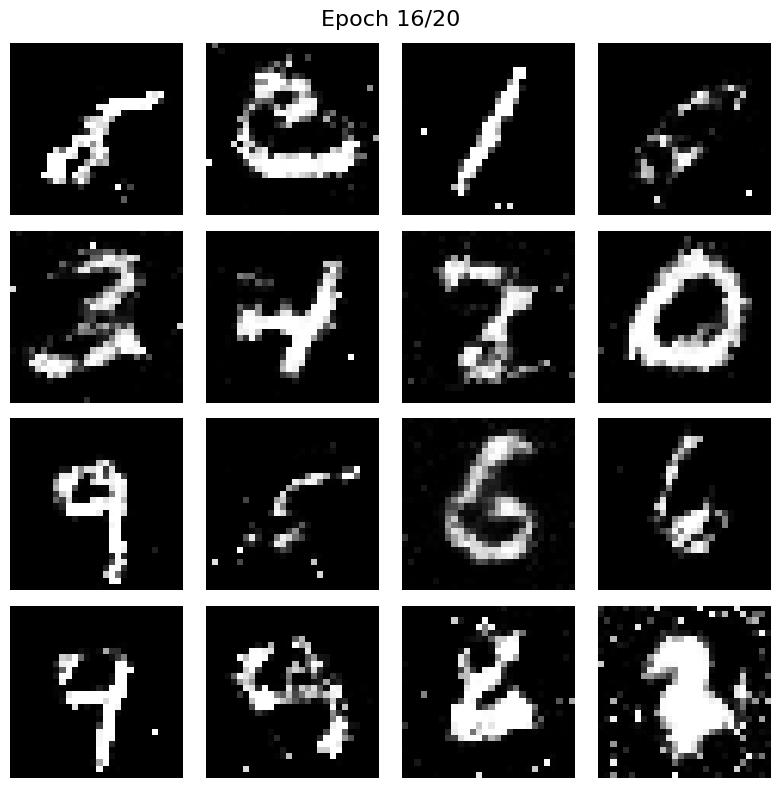

Epoch [17/20]  D Loss: 1.1933  G Loss: 1.0615


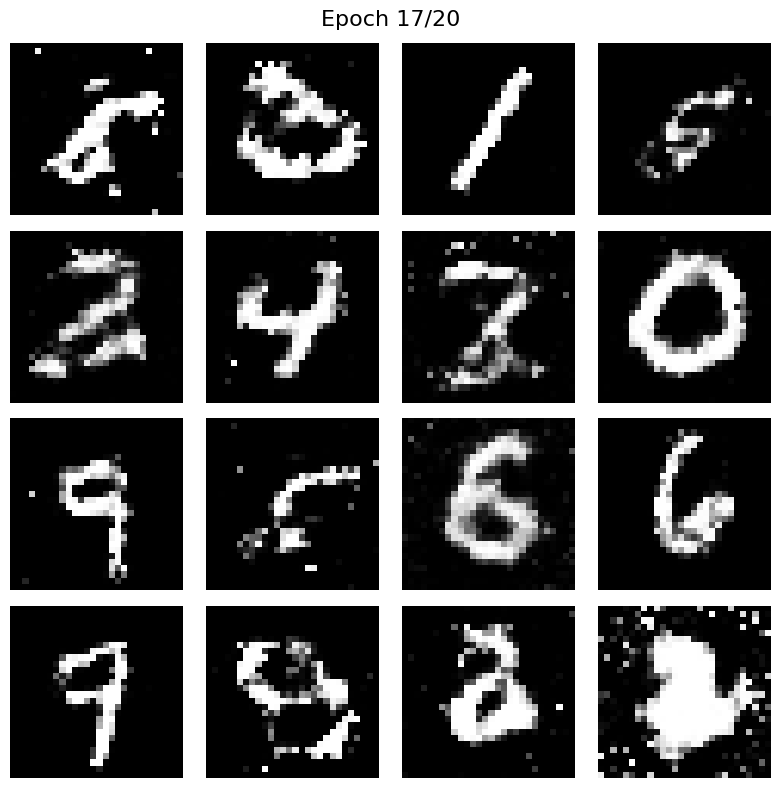

Epoch [18/20]  D Loss: 1.2017  G Loss: 1.0469


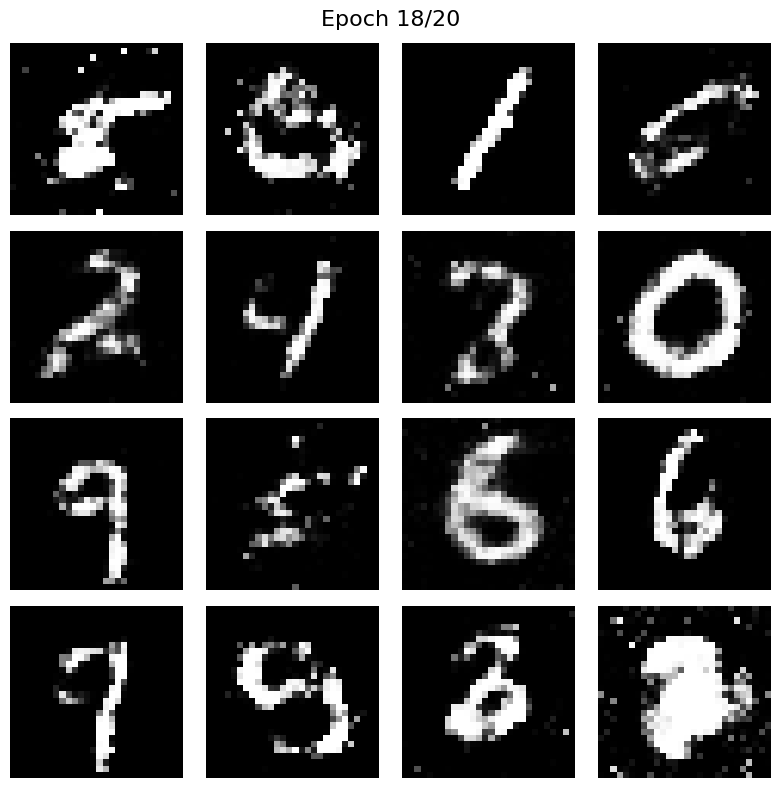

Epoch [19/20]  D Loss: 1.2035  G Loss: 1.0433


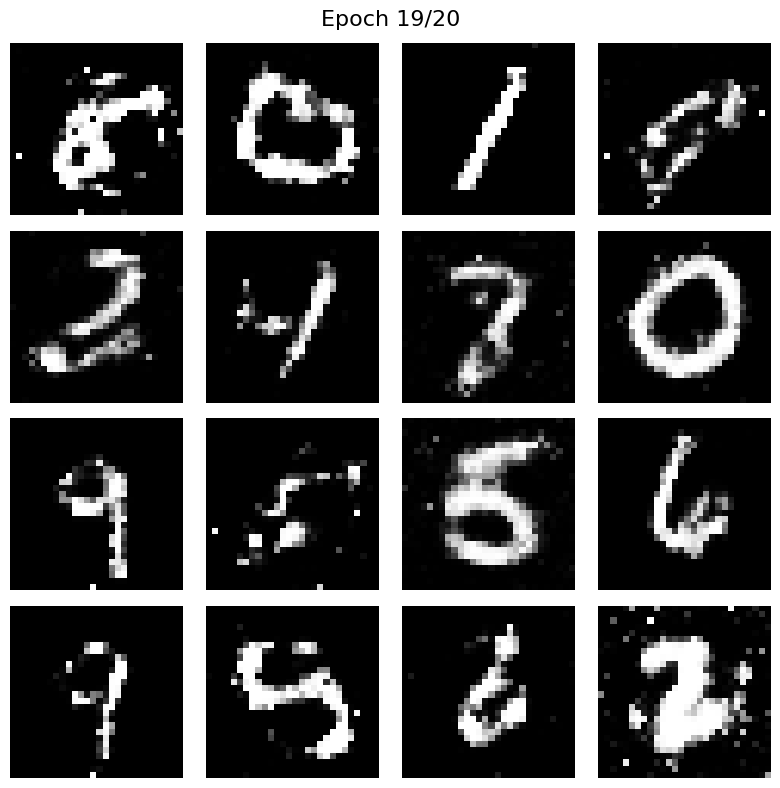

Epoch [20/20]  D Loss: 1.2068  G Loss: 1.0372


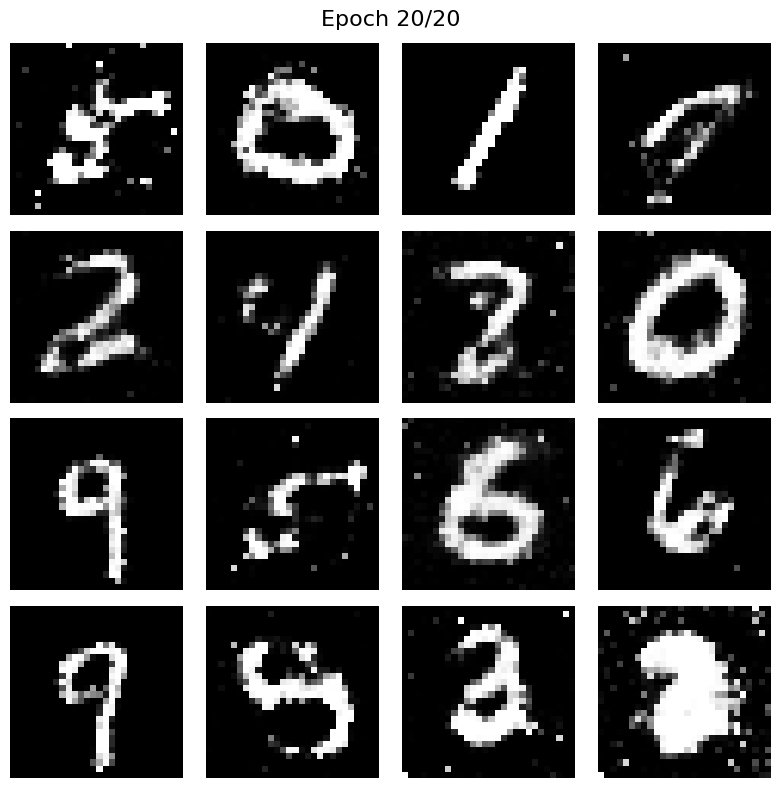

Обучение завершено!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
latent_dim = 100
image_size = 28 * 28
epochs = 20
lr = 0.0002

# Датасет MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Модели и оптимизаторы
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# Фиксированный шум для визуализации прогресса (всегда одни и те же векторы → видим улучшение)
fixed_noise = torch.randn(16, latent_dim, device=device)

# Функция для отображения изображений
def show_generated_images(epoch):
    with torch.no_grad():
        fake_images = generator(fixed_noise).cpu()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f'Epoch {epoch + 1}/{epochs}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Тренировка
print("Начало обучения...")
for epoch in range(epochs):
    d_losses, g_losses = [], []

    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Дискриминатор
        d_optimizer.zero_grad()

        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # Реальные изображения
        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, real_labels)

        # Фейковые изображения
        z = torch.randn(current_batch_size, latent_dim, device=device)
        fake_images = generator(z)
        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Генератор
        g_optimizer.zero_grad()

        output_fake = discriminator(fake_images)  # Повторно пропускаем через D
        g_loss = criterion(output_fake, real_labels)  # Хотим, чтобы D думал, что это реальные
        g_loss.backward()
        g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    # Выводим потери и генерируем изображения после каждой эпохи
    print(f"Epoch [{epoch+1}/{epochs}]  "
          f"D Loss: {np.mean(d_losses):.4f}  "
          f"G Loss: {np.mean(g_losses):.4f}")

    show_generated_images(epoch)

print("Обучение завершено!")